<a href="https://colab.research.google.com/github/LuisAL79/TCCs/blob/main/Analise_dados_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Previsão de Performance**

Análise direta para tentar prever o desempenho de um indivíduo com base em seus hábitos.

* Objetivo: Prever o desempenho em levantamentos de peso.
* Variáveis Alvo (Y): SupinoKg, AgachamentoKg, LevantamentoTerraKg.
  * Regressão: Prever o valor exato em Kg. Isso seria um problema de regressão.

* Variáveis Preditivas (X): Praticamente todas as outras colunas (Idade, Genero, AlturaCm, PesoKg, TempoTreino, TipoTreino, TreinoEstruturado, PlanoAlimentar, FreqTreinoSemana, HorasSono, Suplementos, Fumante, ConsumoAlcool, SatisfacaoProgresso, UsoTecnologia, HorarioTreino, DuracaoTreino, IMC).

* Modelo Sugerido:

   * Regressão: Linear Regression

* Insights Potenciais: Quais fatores (horas de sono, frequência de treino, uso de suplementos, tipo de treino) são os mais preditivos para o aumento da força em cada levantamento?

In [38]:
import pandas as pd
import numpy as np
import gspread

from google.colab import auth
from google.auth import default

auth.authenticate_user()
creds, _ = default()
gs = gspread.authorize(creds)

In [39]:
def spreadsheet_para_df(spreadsheet_name):
  df = gs.open(spreadsheet_name)
  print(f"Worksheets in '{spreadsheet_name}': {df.worksheets()}")
  df = df.get_worksheet(0)
  df = pd.DataFrame(df.get_all_records(value_render_option='UNFORMATTED_VALUE'))
  display(df[:5])
  return df

df = spreadsheet_para_df('Dados_Limpos_TCC')

Worksheets in 'Dados_Limpos_TCC': [<Worksheet 'Página1' id:0>]


,Idade,Genero,AlturaCm,PesoKg,Lesoes,TempoTreino,TipoTreino,TreinoEstruturado,PlanoAlimentar,SupinoKg,...,Progresso3Meses,HorasSono,Suplementos,Fumante,ConsumoAlcool,SatisfacaoProgresso,UsoTecnologia,HorarioTreino,DuracaoTreino,IMC
0,24,Feminino,1.61,75.0,não,5,Muscula,1,0,30,...,1,7,Proteina,0,0,0,1,2,60,28.934069
1,24,Masculino,1.70,71.0,não,36,Muscula,0,0,50,...,1,7,creatina,0,1,1,0,2,60,24.567474
2,23,Feminino,1.62,61.0,não,5,Muscula,1,0,20,...,1,8,nenhum,0,0,0,0,1,90,23.243408
3,19,Feminino,1.75,68.0,não,5,Muscula,0,1,10,...,1,8,nenhum,0,1,1,0,1,60,22.204082
4,27,Masculino,1.70,80.0,não,12,Muscula,1,1,40,...,2,8,nenhum,0,0,2,1,1,60,27.681661


In [40]:
for col in df.select_dtypes(include='number'):
  df[col] = df[col].fillna(round(df[col].mean()))

---
**Execução do modelo**

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                                  classification_report,)
from scipy.stats import pearsonr, spearmanr

In [42]:
# Criar o transformer para colunas categóricas
colunas_categoricas = ['TipoTreino', 'Suplementos', 'Genero']
transformador = ColumnTransformer(
    transformers=[
        ('onehot' ,OneHotEncoder(sparse_output=False), colunas_categoricas)
    ],
    remainder='passthrough'  # mantem as outras colunas (ex: numéricas)
)

# Aplicar a transformação
encoded_array = transformador.fit_transform(df)
# Recuperar nomes das novas colunas
novas_colunas = transformador.get_feature_names_out()
# remove remainder__ and onehot__
nomes_limpos = [col.split('__')[-1] for col in novas_colunas]

# Criar novo DataFrame com colunas codificadas
df = pd.DataFrame(encoded_array, columns=nomes_limpos)

df = df.infer_objects() # Uma opção, tentar inferir o melhor dtype
#df = df1.convert_dtypes() # Opção mais moderna e recomendada para dtypes nativos do Pandas (nullable)

df[:5]

,TipoTreino_Cardio,TipoTreino_Crossfit,TipoTreino_Funcional,TipoTreino_Muscula,TipoTreino_Outro,Suplementos_Proteina,Suplementos_creatina,Suplementos_nenhum,Suplementos_outros,Suplementos_termogenico,...,FreqTreinoSemana,Progresso3Meses,HorasSono,Fumante,ConsumoAlcool,SatisfacaoProgresso,UsoTecnologia,HorarioTreino,DuracaoTreino,IMC
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5,1,7,0,0,0,1,2,60,28.934069
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,5,1,7,0,1,1,0,2,60,24.567474
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5,1,8,0,0,0,0,1,90,23.243408
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3,1,8,0,1,1,0,1,60,22.204082
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5,2,8,0,0,2,1,1,60,27.681661


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TipoTreino_Cardio         219 non-null    float64
 1   TipoTreino_Crossfit       219 non-null    float64
 2   TipoTreino_Funcional      219 non-null    float64
 3   TipoTreino_Muscula        219 non-null    float64
 4   TipoTreino_Outro          219 non-null    float64
 5   Suplementos_Proteina      219 non-null    float64
 6   Suplementos_creatina      219 non-null    float64
 7   Suplementos_nenhum        219 non-null    float64
 8   Suplementos_outros        219 non-null    float64
 9   Suplementos_termogenico   219 non-null    float64
 10  Genero_Feminino           219 non-null    float64
 11  Genero_Masculino          219 non-null    float64
 12  Genero_Prefiro não dizer  219 non-null    float64
 13  Idade                     219 non-null    int64  
 14  AlturaCm  

In [44]:
df.columns

Index(['TipoTreino_Cardio', 'TipoTreino_Crossfit', 'TipoTreino_Funcional',
       'TipoTreino_Muscula', 'TipoTreino_Outro', 'Suplementos_Proteina',
       'Suplementos_creatina', 'Suplementos_nenhum', 'Suplementos_outros',
       'Suplementos_termogenico', 'Genero_Feminino', 'Genero_Masculino',
       'Genero_Prefiro não dizer', 'Idade', 'AlturaCm', 'PesoKg', 'Lesoes',
       'TempoTreino', 'TreinoEstruturado', 'PlanoAlimentar', 'SupinoKg',
       'AgachamentoKg', 'LevantamentoTerraKg', 'FreqTreinoSemana',
       'Progresso3Meses', 'HorasSono', 'Fumante', 'ConsumoAlcool',
       'SatisfacaoProgresso', 'UsoTecnologia', 'HorarioTreino',
       'DuracaoTreino', 'IMC'],
      dtype='object')

In [45]:
col_features = ['TipoTreino_Muscula',
              'PlanoAlimentar', 'FreqTreinoSemana', 'Suplementos_cretina',
                'Altura_Cm', 'DuracaoTreino', 'PesoKg']

col_target = ['SupinoKg', 'AgachamentoKg', 'LevantamentoTerraKg']

In [46]:
dfn = df.copy()
col_features = ['TipoTreino_Muscula',
              'PlanoAlimentar', 'FreqTreinoSemana', 'Suplementos_creatina',
                'AlturaCm', 'DuracaoTreino', 'PesoKg']

col_target = ['SupinoKg', 'AgachamentoKg', 'LevantamentoTerraKg']

X = dfn[col_features]
ys, ya, ylt = dfn[col_target[0]], dfn[col_target[1]], dfn[col_target[2]]
y = ya

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

print(f"\nTamanho do conjunto de treino (X - Múltipla): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X - Múltipla): {X_test.shape}")


Tamanho do conjunto de treino (X - Múltipla): (175, 7)
Tamanho do conjunto de teste (X - Múltipla): (44, 7)


In [47]:
dfn[y.name]

,AgachamentoKg
0,50
1,160
2,40
3,30
4,50
...,...
214,40
215,10
216,70
217,30



--- Correlações ---


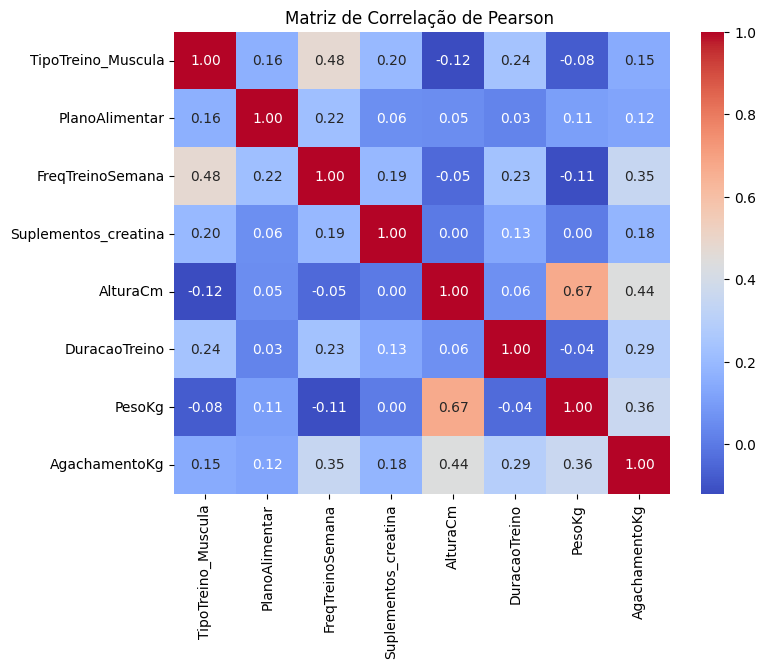

In [48]:
print("\n--- Correlações ---")
plt.figure(figsize=(8, 6))
#sns.heatmap(dfn[col_features+[col_target[1]]].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
sns.heatmap(dfn[col_features+[y.name]].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação de Pearson ')
plt.show()

In [49]:
# Inicializando e treinando o modelo de Regressão Linear Múltipla
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model_lr.predict(X_test)

print("\n--- Regressão Linear Múltipla ---")
print(f"Coeficientes do modelo: {model_lr.coef_}")
print(f"Intercepto do modelo: {model_lr.intercept_:.2f}")


--- Regressão Linear Múltipla ---
Coeficientes do modelo: [  3.92819668   3.5170225    7.24437106   6.71403195 113.77502992
   0.29787684   0.48856435]
Intercepto do modelo: -237.21


In [50]:
# Métricas de avaliação

mae_lr = mean_absolute_error(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"\nMAE (Regressão Linear Múltipla): {mae_lr:.2f}")
print(f"MSE (Regressão Linear Múltipla): {mse_lr:.2f}")
print(f"R² (Regressão Linear Múltipla): {r2_lr:.4f}")


MAE (Regressão Linear Múltipla): 28.26
MSE (Regressão Linear Múltipla): 1373.50
R² (Regressão Linear Múltipla): 0.3395


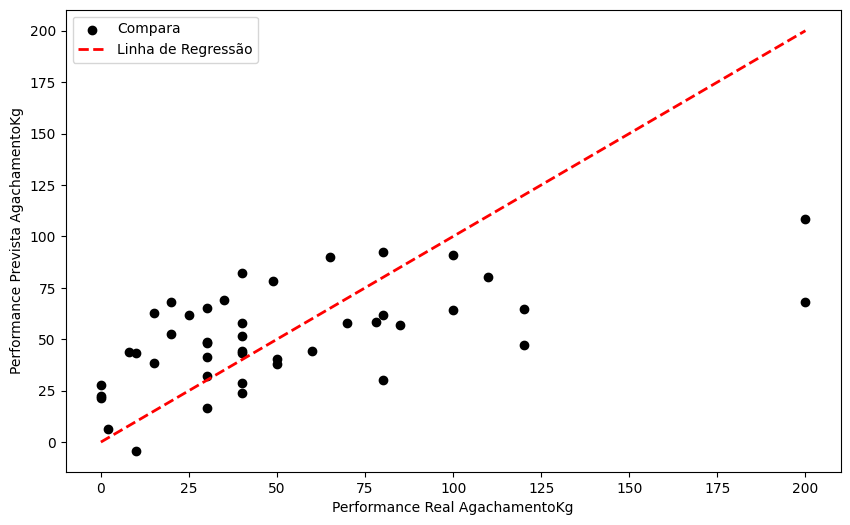

In [51]:
# Visualizando previsões vs. valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=1, c='black',label='Compara')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linha de Regressão')
plt.xlabel(f'Performance Real {y.name}')
plt.ylabel(f'Performance Prevista {y.name}')
#plt.title('Regressão Linear Múltipla: Peef vs. Previstos')
plt.legend()
plt.show()

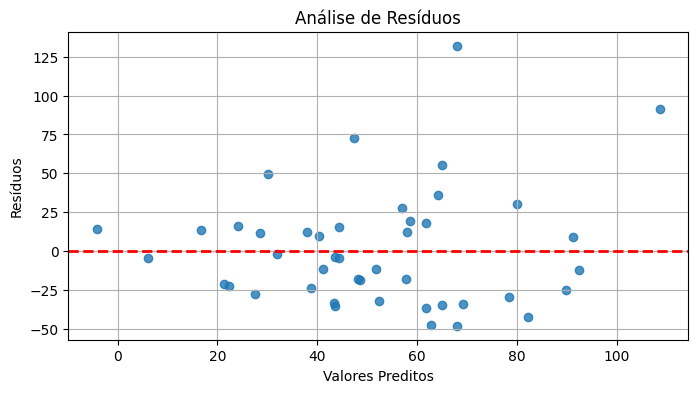

In [52]:
# Residuos
residuos = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuos, alpha=0.8, color='tab:blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Análise de Resíduos')
plt.grid(True)
plt.show()

In [53]:
dfn[col_features+[y.name]][:5]

,TipoTreino_Muscula,PlanoAlimentar,FreqTreinoSemana,Suplementos_creatina,AlturaCm,DuracaoTreino,PesoKg,AgachamentoKg
0,1.0,0,5,0.0,1.61,60,75.0,50
1,1.0,0,5,1.0,1.70,60,71.0,160
2,1.0,0,5,0.0,1.62,90,61.0,40
3,1.0,1,3,0.0,1.75,60,68.0,30
4,1.0,1,5,0.0,1.70,60,80.0,50


In [54]:
# Obter os coeficientes do modelo treinado
intercept = model_lr.intercept_
coefficients = model_lr.coef_

def predict_with_coefficients(feature_values: dict, intercept: float, coefficients: np.ndarray, feature_order: list):
  # Garante que as features de entrada estejam na ordem correta
  ordered_features = np.array([feature_values[feature_name] for feature_name in feature_order])

  # Realiza o cálculo da previsão: Y = beta_0 + beta_1*X_1 + ... + beta_n*X_n
  prediction = intercept + np.dot(ordered_features, coefficients)
  return prediction

new_data_for_prediction = {
    'TipoTreino_Muscula': 0,
    'PlanoAlimentar': 1,
    'FreqTreinoSemana': 5,
    'Suplementos_creatina': 0,
    'AlturaCm': 175,
    'DuracaoTreino': 90,
    'PesoKg': 71
}

# Fazer a previsão usando a nova função
predicted_value = predict_with_coefficients(
    new_data_for_prediction,
    intercept,
    coefficients,
    col_features
)

print(f"\nValores das novas features para previsão: {new_data_for_prediction}")
print(f"Valor previsto pela função: {predicted_value:.2f}")


Valores das novas features para previsão: {'TipoTreino_Muscula': 0, 'PlanoAlimentar': 1, 'FreqTreinoSemana': 5, 'Suplementos_creatina': 0, 'AlturaCm': 175, 'DuracaoTreino': 90, 'PesoKg': 71}
Valor previsto pela função: 19774.66


In [55]:
import numpy as np

# Coeficientes obtidos do modelo treinado
intercept = model_lr.intercept_
coefficients = model_lr.coef_

# Ordem correta das variáveis (exatamente como o modelo foi treinado)
feature_order = [
    'TipoTreino_Muscula',
    'PlanoAlimentar',
    'FreqTreinoSemana',
    'Suplementos_creatina',
    'AlturaCm',
    'DuracaoTreino',
    'PesoKg'
]

# Função para prever com novos dados usando os coeficientes do modelo treinado
def predict_with_coefficients(feature_values: dict, intercept: float, coefficients: np.ndarray, feature_order: list) -> float:
    ordered_features = np.array([feature_values[feature] for feature in feature_order])
    prediction = intercept + np.dot(ordered_features, coefficients)
    return prediction

# Dados novos (nunca vistos pelo modelo)
new_data_for_prediction = {
    'TipoTreino_Muscula': 0,
    'PlanoAlimentar': 1,
    'FreqTreinoSemana': 5,
    'Suplementos_creatina': 0,
    'AlturaCm': 1.75,
    'DuracaoTreino': 90,
    'PesoKg': 71
}

# Fazendo a previsão
predicted_value = predict_with_coefficients(new_data_for_prediction, intercept, coefficients, feature_order)

print(f"Previsão de carga máxima no agachamento: {predicted_value:.2f} kg")


Previsão de carga máxima no agachamento: 63.14 kg


In [56]:
novos_dados = [
    {
        'TipoTreino_Muscula': 0,
        'PlanoAlimentar': 1,
        'FreqTreinoSemana': 5,
        'Suplementos_creatina': 0,
        'AlturaCm': 1.75,
        'DuracaoTreino': 90,
        'PesoKg': 71
    },
    {
        'TipoTreino_Muscula': 1,
        'PlanoAlimentar': 0,
        'FreqTreinoSemana': 3,
        'Suplementos_creatina': 1,
        'AlturaCm': 1.68,
        'DuracaoTreino': 60,
        'PesoKg': 67
    },
    {
        'TipoTreino_Muscula': 1,
        'PlanoAlimentar': 1,
        'FreqTreinoSemana': 6,
        'Suplementos_creatina': 1,
        'AlturaCm': 1.80,
        'DuracaoTreino': 75,
        'PesoKg': 80
    }
]


In [57]:
feature_order = ['TipoTreino_Muscula', 'PlanoAlimentar', 'FreqTreinoSemana',
                 'Suplementos_creatina', 'AlturaCm', 'DuracaoTreino', 'PesoKg']

for i, entrada in enumerate(novos_dados, 1):
    previsao = predict_with_coefficients(entrada, intercept, coefficients, feature_order)
    print(f"Exemplo {i}: Previsão de carga máxima no agachamento = {previsao:.2f} kg")


Exemplo 1: Previsão de carga máxima no agachamento = 63.14 kg
Exemplo 2: Previsão de carga máxima no agachamento = 36.92 kg
Exemplo 3: Previsão de carga máxima no agachamento = 86.64 kg
